In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['rapl'])
from common import *
from plotcommon import *
from cla_util import *
from rayleigh_diagnostics import GridInfo

In [2]:
dirname = '/nobackup/lmatilsk/benchmarks/c2001_case0/00_test_equations_1k_iter/'

In [3]:
the_file = get_widest_range_file (dirname + 'data/', 'Point_Probes_trace')
print ('the_file = ', the_file)

the_file =  /nobackup/lmatilsk/benchmarks/c2001_case0/00_test_equations_1k_iter/data/Point_Probes_trace-00101000_00101000.pkl


In [4]:
# get point probes data
di = get_dict(the_file)
vals = di['vals']

times = di['times']
dt = times[2:] - times[1:-1]
dt = dt.reshape((len(dt), 1, 1, 1))
dt_old = times[1:-1] - times[:-2]
dt_old = dt_old.reshape((len(dt_old), 1, 1, 1))

iters = di['iters']
lut = di['lut']
rvals = di['rvals']
thetavals = di['thetavals']
phivals = di['phivals']

# get grid info
di_grid = get_grid_info(dirname)
rr = di_grid['rr']
tt = di_grid['tt']
phi = di_grid['phi']
tt_lat = di_grid['tt_lat']
lons = di_grid['lons']

irvals = inds_from_vals(rr, rvals)
ithetavals = inds_from_vals(tt, thetavals)
iphivals = inds_from_vals(phi, phivals)

print ('nphi =', di_grid['nphi'])
print ('iphivals = ', iphivals)

print ('ntheta =', di_grid['nt'])
print ('ithetavals = ', ithetavals)

print('nr =', di_grid['nr'])
print ('irvals = ', irvals)

nphi = 128
iphivals =  [  0  16  32  48  63  79  95 111]
ntheta = 64
ithetavals =  [ 3  8 16 24 32 39 47 55 60]
nr = 48
irvals =  [ 4  7 11 13 15 18 20 21 22 23 24 25 27 29 32 34 36 40 43]


In [5]:
print (np.shape(vals[0, ..., 0]))

(8, 9, 19)


In [6]:
# pick a point
#iphi0, it0, ir0 = 4, 5, 11
iphi0, it0, ir0 = 5, 2, 0

In [7]:
prot = compute_Prot(dirname)
t = times/prot

In [33]:
print(np.mean(np.diff(times)))
print(np.std(np.diff(times)))
print (len(times))

9.999999999976694e-05
0.0
1000


In [9]:
def my_maxabs(*args):
    the_shape = np.shape(args[0])
    maxabs = np.zeros(the_shape) - np.inf
    for arg in args:
        maxabs = np.maximum(maxabs, arg)
    return maxabs

In [10]:
# r momentum 
rhov_r = vals[..., lut[201]]

adv_r = -vals[..., lut[1201]]
cor_r = vals[..., lut[1219]]
fexp_r = adv_r + cor_r

visc_r = vals[..., lut[1228]]
gradp_r = vals[..., lut[1237]]
buoy = vals[..., lut[1216]]
fimp_r = buoy + visc_r + gradp_r

# max abs (to normalize later)
maxabs_r = my_maxabs(np.abs(adv_r), np.abs(cor_r), np.abs(visc_r), np.abs(gradp_r))

In [11]:
# theta momentum
rhov_t = vals[..., lut[202]]

adv_t = -vals[..., lut[1202]]
cor_t = vals[..., lut[1220]]
fexp_t = adv_t + cor_t

visc_t = vals[..., lut[1229]]
gradp_t = vals[..., lut[1238]]
fimp_t = visc_t + gradp_t

maxabs_t = my_maxabs(np.abs(adv_t), np.abs(cor_t), np.abs(visc_t), np.abs(gradp_t))

In [12]:
# phi momentum
rhov_p = vals[..., lut[203]]

adv_p = -vals[..., lut[1203]]
cor_p = vals[..., lut[1221]]
fexp_p = adv_p + cor_p

visc_p = vals[..., lut[1230]]
gradp_p = vals[..., lut[1239]]
fimp_p = visc_p + gradp_p

maxabs_p = my_maxabs(np.abs(adv_p), np.abs(cor_p), np.abs(visc_p), np.abs(gradp_p))

In [13]:
# heat equation
inte = vals[..., lut[701]]
dy = inte[2:] - inte[1:-1]
dintedt = dy/dt

adv_heat = -vals[..., lut[1401]]
int_heat = vals[..., lut[1434]]
visc_heat = vals[..., lut[1435]]
fexp_heat = adv_heat + int_heat + visc_heat

ref_adv_heat = -vals[..., lut[1479]]
cond_heat = vals[..., lut[1421]]
fimp_heat = ref_adv_heat + cond_heat

maxabs_heat = my_maxabs(np.abs(adv_heat), np.abs(int_heat), np.abs(visc_heat),\
                        np.abs(ref_adv_heat), cond_heat)

In [14]:
# get d lhs / dt (momentum, heat)
dy = rhov_r[2:] - rhov_r[1:-1]
drhovdt_r = dy/dt

dy = rhov_t[2:] - rhov_t[1:-1]
drhovdt_t = dy/dt

dy = rhov_p[2:] - rhov_p[1:-1]
drhovdt_p = dy/dt

dy = inte[2:] - inte[1:-1]
dintedt = dy/dt

In [15]:
# start getting weighted rhs (momentum)

def get_weighted_rhs(fimp, fexp):
    return 0.5*(fimp[2:] + fimp[1:-1]) + fexp[1:-1] + 0.5*(dt/dt_old)*(fexp[1:-1] - fexp[:-2])

fweighted_r = get_weighted_rhs(fimp_r, fexp_r)
fweighted_t = get_weighted_rhs(fimp_t, fexp_t)
fweighted_p = get_weighted_rhs(fimp_p, fexp_p)
fweighted_heat = get_weighted_rhs(fimp_heat, fexp_heat)

Text(0.5, 1.0, 'momentum (r)')

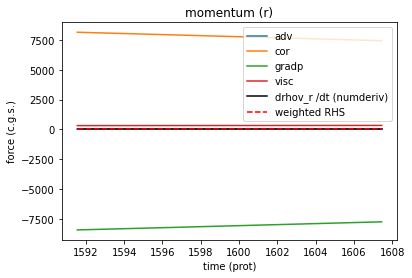

In [16]:
# plot r momentum (all pieces)

# pieces
plt.plot(t, adv_r[:, iphi0, it0, ir0], label='adv')
plt.plot(t, cor_r[:, iphi0, it0, ir0], label='cor')
plt.plot(t, gradp_r[:, iphi0, it0, ir0], label='gradp')
plt.plot(t, visc_r[:, iphi0, it0, ir0], label='visc')

# totals
plt.plot(t[2:], drhovdt_r[:, iphi0, it0, ir0], 'k', label='drhov_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (r)')

Text(0.5, 1.0, 'momentum totals (r)')

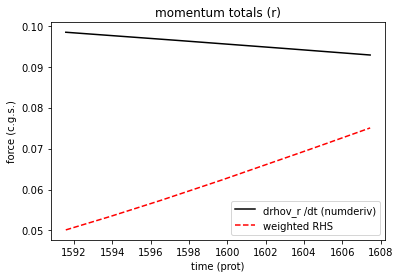

In [17]:
# plot r momentum (totals)
plt.plot(t[2:], drhovdt_r[:, iphi0, it0, ir0], 'k', label='drhov_r /dt (numderiv)')
plt.plot(t[2:], fweighted_r[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (r)')

Text(0.5, 1.0, 'momentum (t)')

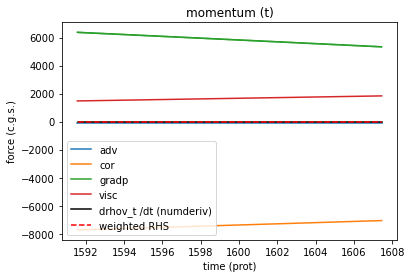

In [18]:
# plot theta momentum (all pieces)

# pieces
plt.plot(t, adv_t[:, iphi0, it0, ir0], label='adv')
plt.plot(t, cor_t[:, iphi0, it0, ir0], label='cor')
plt.plot(t, gradp_t[:, iphi0, it0, ir0], label='gradp')
plt.plot(t, visc_t[:, iphi0, it0, ir0], label='visc')

# totals
plt.plot(t[2:], drhovdt_t[:, iphi0, it0, ir0], 'k', label='drhov_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (t)')

Text(0.5, 1.0, 'momentum totals (t)')

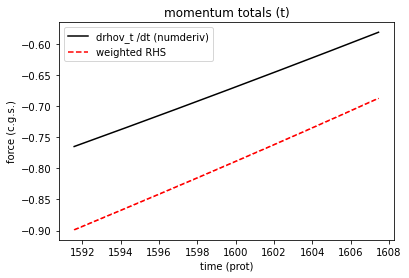

In [19]:
# plot theta momentum (totals)
plt.plot(t[2:], drhovdt_t[:, iphi0, it0, ir0], 'k', label='drhov_t /dt (numderiv)')
plt.plot(t[2:], fweighted_t[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (t)')

Text(0.5, 1.0, 'momentum (p)')

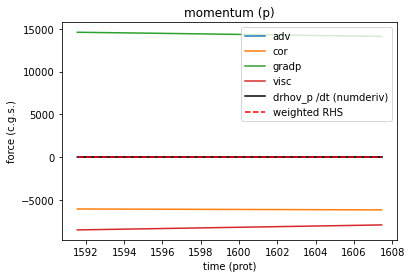

In [20]:
# plot phi momentum (all pieces)

# pieces
plt.plot(t, adv_p[:, iphi0, it0, ir0], label='adv')
plt.plot(t, cor_p[:, iphi0, it0, ir0], label='cor')
plt.plot(t, gradp_p[:, iphi0, it0, ir0], label='gradp')
plt.plot(t, visc_p[:, iphi0, it0, ir0], label='visc')

# totals
plt.plot(t[2:], drhovdt_p[:, iphi0, it0, ir0], 'k', label='drhov_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum (p)')

Text(0.5, 1.0, 'momentum totals (p)')

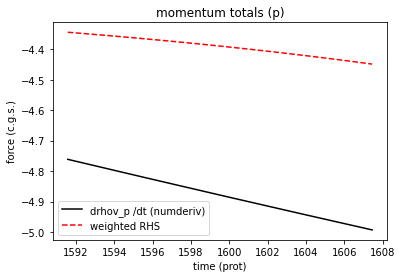

In [21]:
# plot phi momentum (totals)
plt.plot(t[2:], drhovdt_p[:, iphi0, it0, ir0], 'k', label='drhov_p /dt (numderiv)')
plt.plot(t[2:], fweighted_p[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('force (c.g.s.)')
plt.title('momentum totals (p)')

Text(0.5, 1.0, 'heat eq.')

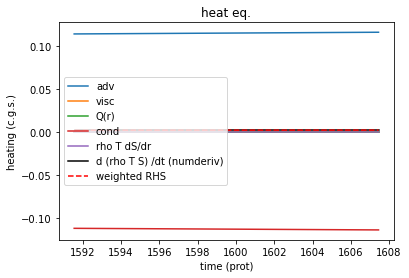

In [22]:
# plot heat equation (all pieces)

# pieces
plt.plot(t, adv_heat[:, iphi0, it0, ir0], label='adv')
plt.plot(t, visc_heat[:, iphi0, it0, ir0], label='visc')
plt.plot(t, int_heat[:, iphi0, it0, ir0], label='Q(r)')
plt.plot(t, cond_heat[:, iphi0, it0, ir0], label='cond')
plt.plot(t, ref_adv_heat[:, iphi0, it0, ir0], label='rho T dS/dr')

# totals
plt.plot(t[2:], dintedt[:, iphi0, it0, ir0], 'k', label='d (rho T S) /dt (numderiv)')
plt.plot(t[2:], fweighted_heat[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('heating (c.g.s.)')
plt.title('heat eq.')

Text(0.5, 1.0, 'heat eq. totals')

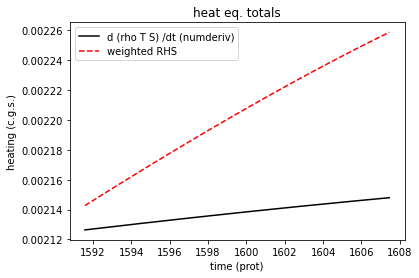

In [23]:
# plot heat equation (totals)

# totals
plt.plot(t[2:], dintedt[:, iphi0, it0, ir0], 'k', label='d (rho T S) /dt (numderiv)')
plt.plot(t[2:], fweighted_heat[:, iphi0, it0, ir0], 'r--', label='weighted RHS')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('heating (c.g.s.)')
plt.title('heat eq. totals')

In [24]:
# quantify the numerical errors
def get_err(diff, norm, point=None, ir=None):
    if not point is None:
        diff = diff[:, point[0], point[1], point[2]]
        norm = norm[:, point[0], point[1], point[2]]
    if not ir is None:
        diff = diff[..., ir]
        norm = norm[..., ir]
        
    denom = norm**2
    for i in range(norm.ndim - 1):
        denom = np.mean(denom, axis=-1)
    denom = np.sqrt(np.mean(denom))
    
    numer = diff**2
    for i in range(norm.ndim - 1):
        numer = np.mean(numer, axis=-1)
    numer = np.sqrt(np.mean(numer))
    return rms(numer/denom)

In [25]:
# stringent error, at the point we plotted
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, fweighted_r, point=(iphi0, it0, ir0)))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, fweighted_t, point=(iphi0, it0, ir0)))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, fweighted_p, point=(iphi0, it0, ir0)))
print ("err heat  = ", get_err(fweighted_heat - dintedt, fweighted_heat, point=(iphi0, it0, ir0)))

err mom r =  0.5525465485136096
err mom t =  0.15115424435873964
err mom p =  0.11110363668001459
err heat  =  0.03220309122326508


In [26]:
# errors (w.r.t. maxabs) at the point we plotted
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, maxabs_r[2:], point=(iphi0, it0, ir0)))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, maxabs_t[2:], point=(iphi0, it0, ir0)))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, maxabs_p[2:], point=(iphi0, it0, ir0)))
print ("err heat  = ", get_err(fweighted_heat - dintedt, maxabs_heat[2:], point=(iphi0, it0, ir0)))

err mom r =  4.28088020115472e-06
err mom t =  1.627960798851544e-05
err mom p =  3.40010019961478e-05
err heat  =  0.000615117404030298


In [27]:
# stringent errors
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, fweighted_r))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, fweighted_t))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, fweighted_p))
print ("err heat  = ", get_err(fweighted_heat - dintedt, fweighted_heat))

err mom r =  0.054336845818130995
err mom t =  0.1713516978470173
err mom p =  0.19879035666685327
err heat  =  0.028888394935549205


In [28]:
# errors (w.r.t. maxabs)
print ("err mom r = ", get_err(fweighted_r - drhovdt_r, maxabs_r[2:]))
print ("err mom t = ", get_err(fweighted_t - drhovdt_t, maxabs_t[2:]))
print ("err mom p = ", get_err(fweighted_p - drhovdt_p, maxabs_p[2:]))
print ("err heat  = ", get_err(fweighted_heat - dintedt, maxabs_heat[2:]))

err mom r =  1.5922887693078144e-05
err mom t =  9.824146768102483e-05
err mom p =  5.49329897638681e-05
err heat  =  0.00047857689061738397


In [29]:
# print error at each radius
print ('mom (r) errors at different radii')
for ir in range(len(irvals)):
    print ('ir = %i:' %ir, 'err = ', get_err(fweighted_r - drhovdt_r, fweighted_r, ir=ir))

mom (r) errors at different radii
ir = 0: err =  0.6825476384903297
ir = 1: err =  0.6547382143557956
ir = 2: err =  0.2504075323811157
ir = 3: err =  0.12371488821627774
ir = 4: err =  0.07090104093082886
ir = 5: err =  0.034141540775107115
ir = 6: err =  0.018624649722788496
ir = 7: err =  0.017120140604066164
ir = 8: err =  0.016537651865408075
ir = 9: err =  0.016100102012290847
ir = 10: err =  0.015530865436376455
ir = 11: err =  0.014462867539014584
ir = 12: err =  0.01172700320482442
ir = 13: err =  0.008988157186090128
ir = 14: err =  0.005949610034455408
ir = 15: err =  0.004733284319164262
ir = 16: err =  0.004348170554398295
ir = 17: err =  0.007668417650157308
ir = 18: err =  0.015931852485562017


In [30]:
# print error at each radius
print ('mom (t) errors at different radii')
for ir in range(len(irvals)):
    print ('ir = %i:' %ir, 'err = ', get_err(fweighted_t - drhovdt_t, fweighted_t, ir=ir))

mom (t) errors at different radii
ir = 0: err =  0.5141651337204903
ir = 1: err =  0.37320539868138314
ir = 2: err =  0.18673553324767087
ir = 3: err =  0.15459445781485884
ir = 4: err =  0.13061918313864465
ir = 5: err =  0.16052321000615793
ir = 6: err =  0.15464227740586572
ir = 7: err =  0.14252916233157376
ir = 8: err =  0.13021868437494644
ir = 9: err =  0.11992880216593062
ir = 10: err =  0.11095397170149711
ir = 11: err =  0.10118077749070867
ir = 12: err =  0.0732660210900587
ir = 13: err =  0.040021337186765205
ir = 14: err =  0.01976977659009377
ir = 15: err =  0.025337078411074604
ir = 16: err =  0.027615574965331357
ir = 17: err =  0.03839135058635347
ir = 18: err =  0.022879517628189676


In [31]:
# print error at each radius
print ('mom (p) errors at different radii')
for ir in range(len(irvals)):
    print ('ir = %i:' %ir, 'err = ', get_err(fweighted_p - drhovdt_p, fweighted_p, ir=ir))

mom (p) errors at different radii
ir = 0: err =  0.635592824868935
ir = 1: err =  0.1412701027702197
ir = 2: err =  0.1929150588967692
ir = 3: err =  0.15911586024702848
ir = 4: err =  0.10388807306069048
ir = 5: err =  0.08229680650796949
ir = 6: err =  0.07477492946047672
ir = 7: err =  0.07406800316284474
ir = 8: err =  0.07638213260386288
ir = 9: err =  0.08063327970865941
ir = 10: err =  0.085519793448931
ir = 11: err =  0.09011813218227038
ir = 12: err =  0.09591845524109553
ir = 13: err =  0.09838057492653365
ir = 14: err =  0.10189134182073628
ir = 15: err =  0.10033058484322502
ir = 16: err =  0.0928307439745741
ir = 17: err =  0.0742290734707223
ir = 18: err =  0.06769825111648999


In [32]:
# print error at each radius
print ('heat errors at different radii')
for ir in range(len(irvals)):
    print ('ir = %i:' %ir, 'err = ', get_err(fweighted_heat - dintedt, fweighted_heat, ir=ir))

heat errors at different radii
ir = 0: err =  0.08489920244881893
ir = 1: err =  0.11287256209873887
ir = 2: err =  0.060291826883375685
ir = 3: err =  0.03434826413704183
ir = 4: err =  0.020177191444937802
ir = 5: err =  0.010022259645352881
ir = 6: err =  0.011929678148905146
ir = 7: err =  0.013774702637897457
ir = 8: err =  0.01559060674015685
ir = 9: err =  0.017296511730983236
ir = 10: err =  0.018895528361930605
ir = 11: err =  0.020420999829277225
ir = 12: err =  0.02340807549557382
ir = 13: err =  0.026525879350685122
ir = 14: err =  0.031535333219550335
ir = 15: err =  0.034870764763019146
ir = 16: err =  0.03822233157374327
ir = 17: err =  0.04643684512013239
ir = 18: err =  0.05341700249470065
